In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings;warnings.filterwarnings('ignore')
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')

from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance


In [2]:
train_path = './train.csv'
test_path  = './test.csv'
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [3]:
train['is_test'] = 0
test['is_test'] = 1
concat = pd.concat([train, test])

# 기준금리 추가하기

In [4]:
base_rate_path  = './기준금리.csv'
base_rate_df = pd.read_csv(base_rate_path)

In [5]:
# 월일 변수를 월과 일로 나누어주고 년 월 일을 합쳐 날짜를 8자리 정수로 표현하기
base_rate_df['년'] = base_rate_df['년'].map(lambda x: str(x))
base_rate_df['월'] = base_rate_df['월일'].map(lambda x : x[:2])
base_rate_df['일'] = base_rate_df['월일'].map(lambda x : x[4:6])
base_rate_df['날짜'] = base_rate_df['년'] + base_rate_df['월'] + base_rate_df['일']
base_rate_df['날짜'] = base_rate_df['날짜'].map(lambda x: int(x))
base_rate_df = base_rate_df[['날짜', '기준금리']]

In [6]:
# concat에 계약년월과 계약일을 합쳐 계약날짜 변수 생성 (8자리 정수)
concat['계약날짜'] = concat['계약년월'] * 100 + concat['계약일']

In [7]:
# concat의 '계약날짜' 값에 따라 '기준금리'를 반환해주는 함수.
def date_to_rate(date):
    for i in range(54, 0, -1): # 기준금리 데이터의 마지막 인덱스(54)에서 하나씩 올라가며 날짜를 비교하면서 기준금리 확인
        if date >= base_rate_df['날짜'][i] and date <base_rate_df['날짜'][i - 1]:
            return base_rate_df['기준금리'][i]
    return base_rate_df['기준금리'][0] # 날짜(date)가 기준금리 데이터의 가장 최신 날짜보다 같거나 크다면 가장 최신 기준금리 반환

# 예:
# date_to_rate(20211126)
# 1.0

In [8]:
# concat_new에 기준금리 변수 추가
concat['기준금리'] = concat['계약날짜'].apply(date_to_rate)

In [ ]:
# '기준금리'열의 데이터 형식을 float로 변경
concat['기준금리'] = concat['기준금리'].astype(float)

In [ ]:
# 추가된 변수 확인
concat[['계약날짜', '기준금리']]

,계약날짜,기준금리
0,20171208,1.5
1,20171222,1.5
2,20171228,1.5
3,20180103,1.5
4,20180108,1.5
...,...,...
9267,20230719,3.5
9268,20230725,3.5
9269,20230827,3.5
9270,20230902,3.5


# 전세가격지수 추가하기

In [ ]:
jeonsae_path  = './아파트전세가격지수.csv'
jeonsae_df = pd.read_csv(jeonsae_path, encoding='cp949')

In [ ]:
# 전세가격지수 데이터를 '년월'과 서울의 '전세가격지수'를 열로 가지는 데이터로 변환
data = {'년월':list(jeonsae_df.columns[1:]), '전세가격지수':list(jeonsae_df.iloc[1])[1:]}
seoul_jeonsae_df = pd.DataFrame(data)
seoul_jeonsae_df.head()

,년월,전세가격지수
0,2003.11,46.7
1,2003.12,46.2
2,2004.01,46.0
3,2004.02,46.3
4,2004.03,46.5


In [ ]:
# 전세가격지수 데이터의 '년월' 형식을 concat의 '계약년월' 형식과 통일
seoul_jeonsae_df['년월'] = seoul_jeonsae_df['년월'].map(lambda x : int(x.split('.')[0]) * 100 + int(x.split('.')[1]))

In [ ]:
# '전세가격지수' 변수가 추가된 concat 데이터
concat = pd.merge(concat, seoul_jeonsae_df, left_on='계약년월', right_on='년월', how='inner').drop('년월', axis=1)

In [ ]:
# concat의 '전세가격지수'열의 형식을 float 변경
concat['전세가격지수'] = concat['전세가격지수'].astype(float)

In [ ]:
# 확인을 위해 concat에서 랜덤으로 10개 샘플 뽑아보기
concat[['계약년월', '전세가격지수']].sample(n=10)

,계약년월,전세가격지수
959520,201104,64.9
95475,201805,92.3
982259,201009,59.5
155183,200904,52.8
626637,201607,89.5
371072,201912,92.0
1062170,200803,54.3
1084349,200707,53.4
69227,201809,92.7
2501,201712,92.7


# 인구밀도 추가

In [ ]:
population_density_path  = './인구밀도.csv'
population_density = pd.read_csv(population_density_path)

In [ ]:
# 맨 위 row를 변수 이름으로 설정
population_density.columns = population_density.iloc[0]
population_density = population_density[1:]
population_density.head()

,동별(1),동별(2),동별(3),인구 (명),면적 (㎢),인구밀도 (명/㎢)
1,합계,소계,소계,9667669,605.21,15974
2,합계,종로구,소계,152211,23.91,6365
3,합계,종로구,사직동,9355,1.23,7606
4,합계,종로구,삼청동,2642,1.49,1773
5,합계,종로구,부암동,9536,2.27,4201


In [ ]:
# concat의 '시군구' 변수에서 동을 분리하여 따로 변수 만들기
concat['동'] = concat['시군구'].map(lambda x : x.split()[2])

In [ ]:
# 인구밀도 데이터 변수의 타입 변환
population_density_new = population_density[['동별(3)', '인구 (명)', '면적 (㎢)', '인구밀도 (명/㎢)']]
population_density_new['인구 (명)'] = population_density_new['인구 (명)'].astype(float)
population_density_new['면적 (㎢)'] = population_density_new['면적 (㎢)'].astype(float)
population_density_new['인구밀도 (명/㎢)'] = population_density_new['인구밀도 (명/㎢)'].astype(float)

In [ ]:
# concat에서 동을 (유사)행정동으로 반환하는 함수
# '동'이 여러 행정동에 걸쳐있는 경우 임으로 걸쳐있는 행정동 중 하나로 선택하였음
def to_hangjungdong(dong):
    if dong in ['금호동1가']: 
        return '금호1가동'
    elif dong in ['봉천동']: # 중앙동은 5개의 동에 걸쳐있음
        return '중앙동'
    elif dong in ['마곡동']: # 마곡동은 가양1동, 방화1동, 발산1동에 걸쳐있음
        return '가양동'
    elif dong in ['내발산동']: # 내발산동은 '발산1동'과 '우장산동'에 걸쳐있음
        return '발산1동'
    elif dong in ['자곡동', '율현동']:
        return '세곡동'
    elif dong in ['금호동2가', '금호동3가']:
        return '금호2.3가동'
    elif dong in ['금호동4가']:
        return '금호4가동'
    elif dong in ['남대문로5가']:
        return '회현동'
    elif dong in ['남산동2가']:
        return '명동'
    elif dong in ['당산동1가', '당산동2가', '당산동3가']:
        return '당산1동'
    elif dong in ['당산동4가', '당산동5가', '당산동6가']:
        return '당산2동'
    elif dong in ['동선동1가', '동선동3가', '동선동4가', '동선동5가', '동소문동6가', '동소문동7가']:
        return '동선동'
    elif dong in ['동소문동5가', '삼선동2가', '삼선동3가', '삼선동4가', '삼선동5가']:
        return '삼선동'
    elif dong in ['만리동2가', '만리동1가']:
        return '중림동'
    elif dong in ['명륜1가', '명륜2가', '명륜3가']:
        return '혜화동'
    elif dong in ['문래동2가', '문래동3가', '문래동4가', '문래동5가', '문래동6가']:
        return '문래동'
    elif dong in ['보문동2가', '보문동3가', '보문동4가', '보문동6가']:
        return '보문동'
    elif dong in ['성북동1가', '동소문동', '동소문동4가']:
        return '성북동'
    elif dong in ['신문로1가', '신문로2가', '내수동', '당주동', '필운동']:
        return '사직동'
    elif dong in ['안암동1가', '안암동3가', '안암동4가', '안암동5가']:
        return '안암동'
    elif dong in ['양평동1가', '양평동2가', '양평동3가']: 
        return '양평1동'
    elif dong in ['양평동4가', '양평동5가', '양평동6가']: # '양평동3가'는 '양평1동'과 '양평2동'에 걸쳐있음 
        return '양평2동'
    elif dong in ['영등포동1가', '영등포동2가', '영등포동3가', '영등포동4가', '영등포동5가', '영등포동7가', '영등포동8가']:
        return '영등포동'
    elif dong in ['용산동2가']:
        return '용산2가동'
    elif dong in ['원효로1가', '원효로2가', '문배동', '신계동']: # 원효로1동, 2동의 인구밀도가 크게 차이나기 떄문에 두 개 분리
        return  '원효로1동'
    elif dong in ['원효로3가', '원효로4가', '산천동', '신창동', '청암동']:
        return '원효로2동'
    elif dong in ['을지로5가', '산림동', '입정동']:
        return '을지로동'
    elif dong in ['인현동2가', '오장동', '충무로4가', '충무로5가']: 
        return '광희동'
    elif dong in ['장충동1가', '장충동2가']:
        return '장충동'
    elif dong in ['청파동1가', '청파동3가']:
        return '청파동'
    elif dong in ['충정로2가', '충정로3가', '합동', '미근동']:
        return '충현동'
    elif dong in ['필동1가', '필동3가', '묵정동', '예장동']:
        return '필동'
    elif dong in ['한강로1가', '한강로2가', '한강로3가', '용산동5가']:
        return '한강로동'
    elif dong in ['회현동1가', '회현동2가', '남창동']:
        return '회현동'
    elif dong in ['천왕동']:
        return '오류동'
    elif dong in ['온수동', '궁동']:
        return '수궁동'
    elif dong in ['용두동', '신설동']:
        return '용신동'
    elif dong in ['본동']:
        return '노량진동'
    elif dong in ['동작동']:
        return '사당동'
    elif dong in ['노고산동']:
        return '대흥동'
    elif dong in ['마포동']:
        return '도화동'
    elif dong in ['상수동']:
        return '서강동'
    elif dong in ['신공덕동']:
        return '공덕동'
    elif dong in ['동교동']:
        return '연남동'
    elif dong in ['중동']:
        return '성산동'
    elif dong in ['창전동', '하중동']:
        return '서강동'
    elif dong in ['냉천동', '영천동', '현저동']:
        return '천연동'
    elif dong in ['토정동']:
        return '용강동'
    elif dong in ['현석동', '구수동']:
        return '신수동'
    elif dong in ['대현동', '창천동']:
        return '신촌동'
    elif dong in ['우면동']:
        return '양재동'
    elif dong in ['도선동', '상왕십리동', '하왕십리동', '홍익동']:
        return '왕십리도선동'
    elif dong in ['상월곡동', '하월곡동']:
        return '월곡동'
    elif dong in ['신천동']:
        return '잠실동'
    elif dong in ['여의도동']:
        return '여의동'
    elif dong in ['갈월동', '동자동']:
        return '남영동'
    elif dong in ['도원동']:
        return '용문동'
    elif dong in ['동빙고동', '주성동']:
        return '서빙고동'
    elif dong in ['익선동', '견지동', '인의동', '수송동', '원남동', '낙원동']:
        return '종로1.2.3.4가동'
    elif dong in ['효제동', '충신동', '연지동']:
        return '종로5.6가동'
    elif dong in ['교북동', '행촌동', '홍파동', '평동']:
        return '교남동'
    elif dong in ['누상동', '옥인동', '청운동', '통인동', '신교동']:
        return '청운효자동'
    elif dong in ['동숭동', '연건동']:
        return '이화동'
    elif dong in ['신영동']:
        return '부암동'
    elif dong in ['순화동', '정동']:
        return '소공동'
    elif dong in ['흥인동']:
        return '신당동'
    elif dong in ['구기동']:
        return '평창동'
    else:
        return dong
    

In [ ]:
# concat의 '동'을 유사 행정동으로 변환
concat['동'] = concat['동'].apply(to_hangjungdong)

In [ ]:
# 인구밀도 데이터의 몇 개의 행정동을 하나로 합쳐주기 위한 리스트
dong_merge_list = [['성수동1가', '성수1가1동','성수1가2동'],
                   ['성수동2가', '성수2가1동', '성수2가3동'],
                   ['논현동', '논현1동', '논현2동'],
                   ['대치동', '대치1동', '대치2동', '대치4동'],
                   ['도곡동', '도곡1동', '도곡2동'],
                   ['역삼동', '역삼1동', '역삼2동'],
                   ['일원동', '일원본동', '일원1동'],
                   ['고덕동', '고덕1동', '고덕2동'],
                   ['둔촌동', '둔촌1동', '둔촌2동'],
                   ['명일동', '명일1동', '명일2동'],
                   ['상일동', '상일1동', '상일2동'],
                   ['성내동', '성내1동', '성내2동', '성내3동'],
                   ['암사동', '암사1동', '암사2동', '암사3동'],
                   ['천호동', '천호1동', '천호2동', '천호3동'],
                   ['번동', '번1동', '번2동', '번3동'],
                   ['가양동', '가양1동', '가양2동', '가양3동'],
                   ['수유동', '수유1동', '수유2동', '수유3동'],
                   ['등촌동', '등촌1동', '등촌2동', '등촌3동'],
                   ['방화동', '방화1동', '방화2동', '방화3동'],
                   ['화곡동', '화곡1동', '화곡2동',  '화곡3동', '화곡4동', '화곡6동', '화곡8동', '화곡본동'],
                   ['구의동', '구의1동', '구의2동', '구의3동'],
                   ['자양동', '자양1동', '자양2동', '자양3동', '자양4동'],
                   ['개봉동', '개봉1동', '개봉2동', '개봉3동'],
                   ['고척동', '고척1동', '고척2동'],
                   ['중곡동', '중곡1동', '중곡2동', '중곡3동'],
                   ['구로동', '구로1동', '구로2동', '구로3동', '구로4동', '구로5동'],
                   ['개포동', '개포1동', '개포2동', '개포3동', '개포4동'],
                   ['오류동', '오류1동', '오류2동'],
                   ['독산동', '독산1동', '독산2동', '독산3동', '독산4동'],
                   ['시흥동', '시흥1동', '시흥2동', '시흥3동', '시흥4동', '시흥5동'],
                   ['공릉동', '공릉1동', '공릉2동'],
                   ['상계동', '상계1동', '상계2동', '상계5동', '상계8동', '상계9동', '상계10동', '상계3.4동', '상계6.7동'],
                   ['월계동', '월계1동', '월계2동', '월계3동'],
                   ['중계동', '중계본동', '중계1동', '중계4동', '중계2.3동'],
                   ['하계동', '하계1동', '하계2동'],
                   ['도봉동', '도봉1동', '도봉2동'],
                   ['방학동', '방학1동', '방학2동', '방학3동'],
                   ['쌍문동', '쌍문1동', '쌍문2동', '쌍문3동', '쌍문4동'],
                   ['창동', '창1동', '창2동', '창3동', '창4동', '창5동'],
                   ['답십리동', '답십리1동', '답십리2동'],
                   ['이문동', '이문1동', '이문2동'],
                   ['장안동', '장안1동', '장안2동'],
                   ['전농동', '전농1동', '전농2동'],
                   ['휘경동', '휘경1동', '휘경2동'],
                   ['노량진동', '노량진1동', '노량진2동'],
                   ['사당동', '사당1동', '사당2동', '사당3동', '사당4동', '사당5동'],
                   ['상도동', '상도1동', '상도2동', '상도3동', '상도4동'],
                   ['신대방동', '신대방1동', '신대방2동'],
                   ['성산동', '성산1동', '성산2동'],
                   ['신정동', '신정1동', '신정2동', '신정3동', '신정4동', '신정6동', '신정7동'],
                   ['망원동', '망원1동', '망원2동'],
                   ['남가좌동', '남가좌1동', '남가좌2동'],
                   ['북가좌동', '북가좌1동', '북가좌2동'],
                   ['홍은동', '홍은1동', '홍은2동'],
                   ['홍제동', '홍제1동', '홍제2동', '홍제3동'],
                   ['반포동', '반포본동', '반포1동', '반포2동', '반포3동', '반포4동'],
                   ['방배동', '방배본동', '방배1동', '방배2동', '방배3동', '방배4동'],
                   ['서초동', '서초1동', '서초2동', '서초3동', '서초4동'],
                   ['양재동', '양재1동', '양재2동'],
                   ['행당동', '행당1동', '행당2동'],
                   ['길음동', '길음1동', '길음2동'],
                   ['돈암동', '돈암1동', '돈암2동'],
                   ['장위동', '장위1동', '장위2동', '장위3동'],
                   ['정릉동', '정릉1동', '정릉2동', '정릉3동', '정릉4동'],
                   ['가락동', '가락본동', '가락1동', '가락2동'],
                   ['거여동', '거여1동', '거여2동'],
                   ['마천동', '마천1동', '마천2동'],
                   ['문정동', '문정1동', '문정2동'],
                   ['송파동', '송파1동', '송파2동'],
                   ['방이동',  '방이1동', '방이2동'],
                   ['잠실동', '잠실본동', '잠실2동', '잠실3동', '잠실4동', '잠실6동', '잠실7동'],
                   ['풍납동', '풍납1동', '풍납2동'],
                   ['목동', '목1동', '목2동', '목3동', '목4동'],
                   ['신월동', '신월1동', '신월2동', '신월3동', '신월4동', '신월5동', '신월6동', '신월7동'],
                   ['당산동', '당산1동', '당산2동'],
                   ['대림동', '대림1동', '대림2동', '대림3동'],
                   ['신길동', '신길1동', '신길3동', '신길4동', '신길5동', '신길6동', '신길7동'],
                   ['이촌동', '이촌1동', '이촌2동'],
                   ['이태원동', '이태원1동', '이태원2동'],
                   ['불광동', '불광1동', '불광2동'],
                   ['갈현동', '갈현1동', '갈현2동'],
                   ['응암동', '응암1동', '응암2동', '응암3동'],
                   ['숭인동', '숭인1동', '숭인2동'],
                   ['창신동', '창신1동', '창신2동', '창신3동'],
                   ['망우동', '망우본동', '망우3동'],
                   ['면목동', '면목본동', '면목2동', '면목4동', '면목5동', '면목7동', '면목3.8동'],
                   ['묵동', '묵1동', '묵2동'],
                   ['상봉동', '상봉1동', '상봉2동'],
                   ['신내동', '신내1동', '신내2동'],
                   ['중화동', '중화1동', '중화2동'],
                   ['월곡동', '월곡1동', '월곡2동']
                   ]

In [ ]:
# 행정동을 합쳐 유사 행정동을 구하고 합친 인구와 면적을 사용하여 밀도를 다시 구하기
for dongs in dong_merge_list:
    dong_dict ={}
    dong_dict['동별(3)'] = dongs[0]
    dong_pop = 0
    dong_area = 0
    for dong in dongs[1:]:
        dong_pop += population_density_new.loc[population_density_new['동별(3)'] == dong, '인구 (명)'].values[0]
        dong_area += population_density_new.loc[population_density_new['동별(3)'] == dong, '면적 (㎢)'].values[0]
    dong_density = dong_pop / dong_area
    dong_dict['인구 (명)'] = dong_pop
    dong_dict['면적 (㎢)'] = dong_area
    dong_dict['인구밀도 (명/㎢)'] = dong_density
    population_density_new = population_density_new.append(dong_dict, ignore_index=True)
    

In [ ]:
# '인구밀도 (명/㎢)' 변수가 추가된 concat 데이터
concat = pd.merge(concat, population_density_new, left_on='동', right_on='동별(3)', how='inner').drop(['동별(3)', '인구 (명)', '면적 (㎢)'], axis=1)

In [ ]:
# 확인을 위해 concat에서 랜덤으로 10개 샘플 뽑아보기
concat[['동', '인구밀도 (명/㎢)']].sample(n=10)

,동,인구밀도 (명/㎢)
724057,반포동,15277.759473
1040196,구산동,23203.000000
408091,상계동,12722.130102
709730,홍제동,18122.006472
314729,구로동,24740.264650
670673,신정동,24626.264045
973535,당산2동,23937.000000
896413,방이동,32164.615385
1029536,용문동,41657.000000
158597,번동,18606.642066


# 결측치 채우기

In [ ]:
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

In [ ]:
house_df_path = "./서울시 공동주택 아파트 정보.csv"
house_df = pd.read_csv(house_df_path, encoding='cp949')

In [ ]:
# '도로명주소'을 기준으로 df_train의 결측치 ('아파트명'은 같은 아파트임에도 서로 일치하지 않는 항목이 많아서)
house_df['도로명주소'] = house_df['주소(도로명)'] + ' ' + house_df['주소(도로상세주소)']
house_df = house_df.drop_duplicates(subset='도로명주소')

In [ ]:
# house_df_unique에서 '도로명주소'가 같은 경우 수치형인 열은 평균값으로, 범주형인 열은 최빈값으로 중복값 대체
def handle_duplicates(df):
    duplicates = df.duplicated(subset=['도로명주소'])
    for col in df.columns:
        if col != '도로명주소':
            if df[col].dtype == 'int64':
                df[col] = df.groupby('도로명주소')[col].transform(lambda x: x.mean() if not x.isnull().all() else x)
            else:
                df[col] = df.groupby('도로명주소')[col].transform(lambda x: x.mode().iloc[0] if not x.isnull().all() else x)
    df = df.drop_duplicates(subset=['도로명주소'])
    return df

house_df = handle_duplicates(house_df)

In [ ]:
# concat과 house_df_unique에 공통으로 존재하는 열 찾기
common_cols = []
for col_1 in (concat.columns):
    for col_2 in list(list(house_df.columns)):
        if col_1 == col_2:
            common_cols.append(col_1)
            break
common_cols.remove('k-전화번호')
common_cols.remove('k-팩스번호')
common_cols.remove('k-홈페이지')

In [ ]:
# concat의 결측치를 house_df_unique로 채우기
for col in common_cols:
    concat[col] = concat[col].fillna(concat['도로명'].map(house_df.set_index('도로명주소')[col]))
concat[col] = concat['아파트명'].fillna(concat['도로명'].map(house_df.set_index('도로명주소')['k-아파트명']))

In [ ]:
# 결측치가 50만개 이상인 변수 제외
cols_selected = list(concat.columns[concat.isnull().sum() <= 500000])
concat_new = concat[cols_selected]
print(cols_selected)

['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', 'is_test', '계약날짜', '기준금리', '전세가격지수', '동', '인구밀도 (명/㎢)']


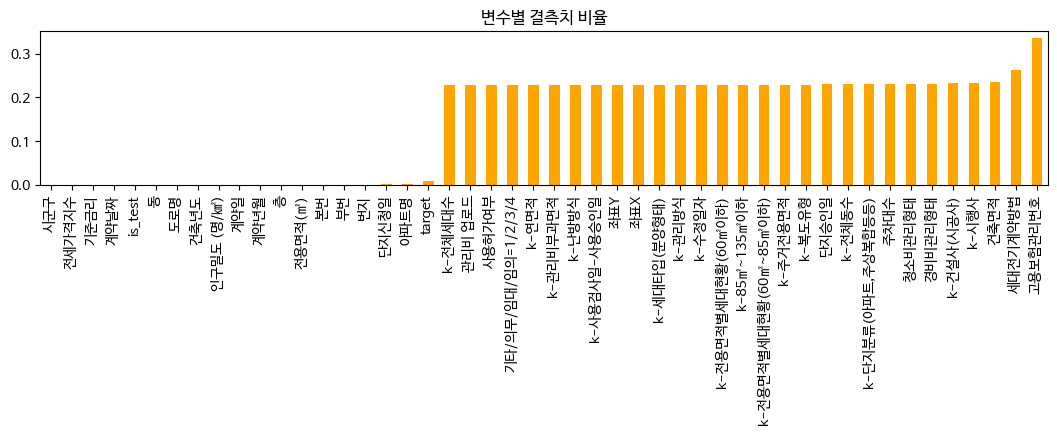

In [ ]:
fig = plt.figure(figsize=(13, 2))
missing = concat_new.isnull().sum() / concat_new.shape[0]
missing = missing[missing >= 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

# 아파트명 변수의 값을 단순화하기

In [ ]:
concat_new['k-건설사(시공사)'] = concat_new['k-건설사(시공사)'].astype(str)

In [ ]:
# 여러 건설사가 같이 시공하였을 시 더 브랜드 평판이 높은 건설사 혹은 데이터가 더 많은 건설사로 대체
def simple_apt(apt):
    if '현대건설' in apt or '힐스테이트' in apt:
        return '현대건설'
    elif '삼성물산' in apt:
        return '삼성물산'
    elif '대우건설' in apt or '푸르지오' in apt:
        return '대우건설'
    elif 'GS' in apt or 'gs' in apt or '지에스' in apt:
        return 'GS건설'
    elif '포스코' in apt:
        return '포스코건설'
    elif '래미안' in apt or '삼성물산' in apt:
        return '삼성물산'
    elif 'DL' in apt:
        return 'DL E&C'
    elif '롯데건설' in apt or '롯데캐슬' in apt:
        return '롯데건설'
    elif '현대산업' in apt:
        return '현대산업개발'
    elif '한화' in apt:
        return '한화건설'
    elif '쌍용' in apt:
        return '쌍용건설'
    elif apt in ['대한주택공사', 'LH공사', '한국토지주택공사', '한국주택공사', 'LH']:
        return '한국토지주택공사'
    elif '우성' in apt:
        return '우성건설'
    elif '한신' in apt:
        return '한신공영'
    elif '두산건설' in apt:
        return '두산건설'
    elif apt in ['동아건설', '(주)동아건설', '동아건설산업(주)', '동아건설산업', '동아건설(주)', '(주)동아건설산업', '동아,효성', '동아주택']:
        return '동아건설'
    elif '대림산업' in apt:
        return '대림산업'
    elif '벽산건설' in apt:
        return '벽산건설'
    elif '동부건설' in apt:
        return '동부건설'
    else:
        return 'Other'
    
    
concat_new['k-건설사(시공사)'] = concat_new['k-건설사(시공사)'].apply(simple_apt)
concat_new['k-건설사(시공사)'] = concat_new['k-건설사(시공사)'].fillna(value='Other') # 결측치도 'Other'로 통일

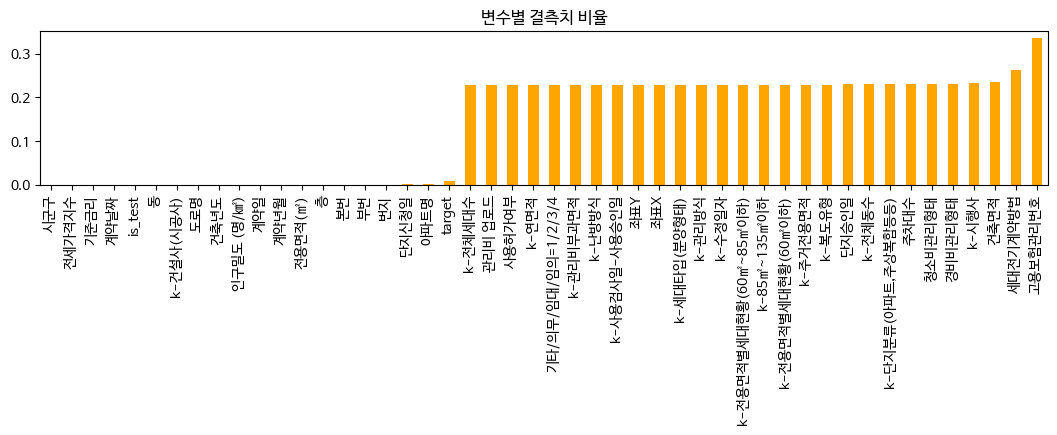

In [ ]:
fig = plt.figure(figsize=(13, 2))
missing = concat_new.isnull().sum() / concat_new.shape[0]
missing = missing[missing >= 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

In [ ]:
concat_new.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호',
       '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4',
       '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target',
       'is_test', '계약날짜', '기준금리', '전세가격지수', '동', '인구밀도 (명/㎢)'],
      dtype='object')

# 간단한 모델 돌려보기

In [ ]:
concat_new = concat_new[['전세가격지수', '기준금리', '동', 'k-건설사(시공사)', '건축년도', '인구밀도 (명/㎢)', '전용면적(㎡)', '층', 'target', 'is_test']]

In [ ]:
concat_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1133641 entries, 0 to 1133640
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   전세가격지수      1133641 non-null  object 
 1   기준금리        1133641 non-null  float64
 2   동           1133641 non-null  object 
 3   k-건설사(시공사)  1133641 non-null  object 
 4   건축년도        1133641 non-null  int64  
 5   인구밀도 (명/㎢)  1133641 non-null  float64
 6   전용면적(㎡)     1133641 non-null  float64
 7   층           1133641 non-null  int64  
 8   target      1124347 non-null  float64
 9   is_test     1133641 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 95.1+ MB


In [ ]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat_new.query('is_test==0')
dt_test = concat_new.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1124347, 9) (9294, 9)


In [ ]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

In [ ]:
# 'k-건설사(시공사)'열 라벨 인코딩

# 아파트별 가격의 평균 내림차순 정렬
apt_price = dt_train.groupby('k-건설사(시공사)')['target'].agg('mean').sort_values(ascending=False)
print('변환전\n', apt_price[:5])

for i, a in enumerate(list(apt_price.index)):
    dt_train.loc[dt_train['k-건설사(시공사)'] == a, 'k-건설사(시공사)'] = i # 라벨 인코딩
    dt_test.loc[dt_test['k-건설사(시공사)'] == a, 'k-건설사(시공사)'] = i
apt_price = dt_train.groupby('k-건설사(시공사)')['target'].agg('mean').sort_values(ascending=False)
print('변환후\n', apt_price[:5])

In [ ]:
# '동'열 라벨 인코딩
dong_price = dt_train.groupby('동')['transaction_real_price'].agg('mean').sort_values(ascending=False)
dong_price[:20]

In [ ]:
# 가격기준으로 동을 정렬한 리스트를 바탕으로 dong에 대해 라벨 인코딩 진행 - 477 it.
for i, d in tqdm(enumerate(list(dong_price.index)), total=len(dong_price)):
    dt_train.loc[dt_train['동'] == d, '동'] = i
    dt_test.loc[dt_test['동'] == d, '동'] = i
dt_train.head()

In [ ]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['기준금리', '건축년도', '인구밀도 (명/㎢)', '전용면적(㎡)', '층', 'target']
범주형 변수: ['전세가격지수', '동', 'k-건설사(시공사)']


In [ ]:
# 가격 로그 변환 후 원래 가격 따로 저장
dt_train['log_target'] = np.log1p(dt_train['target'])
real_target = dt_train['target'] # 원래 가격
dt_train.drop('target', axis=1, inplace=True)
dt_train.head(1)

In [ ]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.hist(real_target, bins=30)
ax1.set_title('Target Distribution')
ax1.set_xlabel('Target')

ax2.hist(dt_train['log_target'], bins=30)
ax2.set_title('Log Target Distribution')
ax2.set_xlabel('Log Target')

plt.show()